## Predict the demand for bike share using known tools (cont.)

### Recreating data from last class

In [90]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

# sample data
bike_data = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/bike_sample.csv")
features = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]

prng = np.random.RandomState(20240306)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)

# feature engineered data
def extract_dt_features(df_with_datetime):
    df_with_datetime['datetime'] = pd.to_datetime(df_with_datetime['datetime'], utc=True)
    df_with_datetime['year'] = df_with_datetime['datetime'].dt.year
    df_with_datetime['day'] = df_with_datetime['datetime'].dt.day
    df_with_datetime['month'] = df_with_datetime['datetime'].dt.month
    df_with_datetime['hour'] = df_with_datetime['datetime'].dt.hour
    df_with_datetime['dayofweek'] = df_with_datetime['datetime'].dt.dayofweek


extract_dt_features(bike_data)

feature_matrix = bike_data.drop(columns=["count", "registered", "casual"]).select_dtypes(include=np.number)
label = bike_data["count"]
prng = np.random.RandomState(20240306)
X_train_fe, X_test_fe, y_train, y_test = train_test_split(feature_matrix, label, test_size=0.2, random_state=prng)

# full data
bike_full = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/train.csv")
extract_dt_features(bike_full)

full_data_without_original_test = bike_full.loc[~bike_full.datetime.isin(bike_data.filter(X_test.index, axis=0)['datetime'])]
full_data_without_original_test.shape

X_full = full_data_without_original_test.drop(columns=["count", "registered", "casual", "datetime"])
y_full = full_data_without_original_test['count']

### Evaluation function

In [6]:
# define loss function
def calculateRMSLE(prediction, y_obs):
    return round(np.sqrt(
        np.mean(
            (
                np.log(np.where(prediction < 0, 0, prediction) + 1) - 
                np.log(y_obs + 1)
            )**2
        )
    ), 4)

### Model #5: Tree

In [10]:
from sklearn.pipeline import Pipeline
from sklearn import tree

steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=5, random_state=prng))
]
pipe_tree = Pipeline(steps)

models = ["Tree", "Feature engineered tree", "Feature engineered tree large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

tree_results = []

for model, data in zip(models, datasets):

    # fit tree to the training set
    pipe_tree.fit(data[0], data[1])

    # using the index allows us to run the model for the three different variables sets
    train_error = calculateRMSLE(pipe_tree.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_tree.predict(data[2]), y_test)

    tree_result = [model, train_error, test_error]
    tree_results.append(tree_result)

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,1.3021,1.3094
1,Feature engineered tree,0.6092,0.6008
2,Feature engineered tree large n,0.6078,0.5610


The tree model performs significantly better than the other models we were modelling because it can determine which variables to keep and drop, due to tree stacking and developing hundreds of trees and determining which variables are the best, and which need to be dropped. 

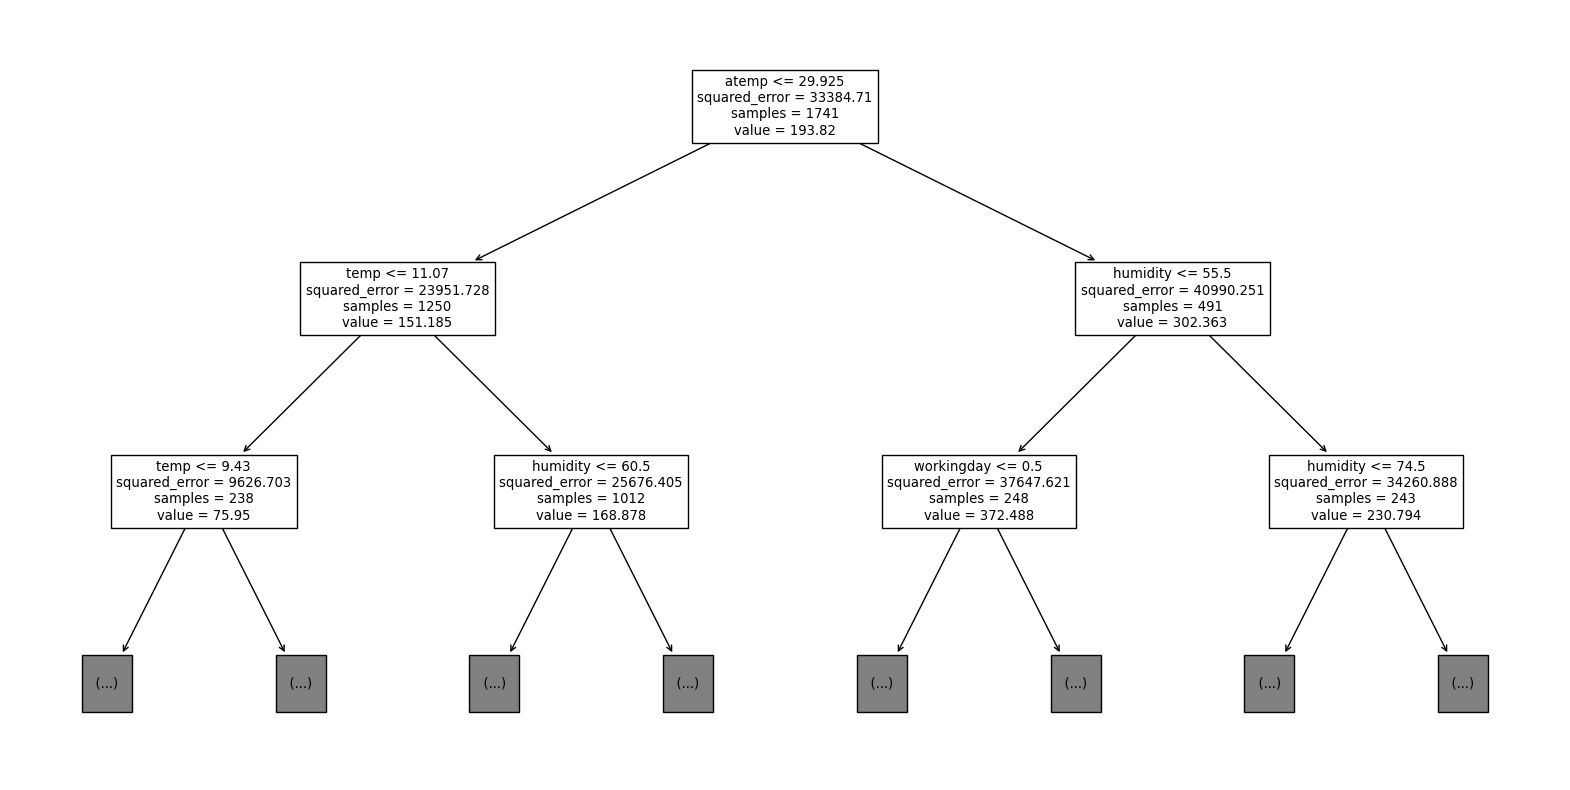

In [9]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20,10))
tree.plot_tree(pipe_tree["tree"], feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [32]:
# change max depth to estimate a deeper model
steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=15, random_state=prng))
]
pipe_tree = Pipeline(steps)

models = ["Tree", "Feature engineered tree", "Feature engineered tree large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

tree_results = []

for model, data in zip(models, datasets):

    # fit tree to the training set
    pipe_tree.fit(data[0], data[1])

    # using the index allows us to run the model for the three different variables sets
    train_error = calculateRMSLE(pipe_tree.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_tree.predict(data[2]), y_test)

    tree_result = [model, train_error, test_error]
    tree_results.append(tree_result)

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,0.4811,1.4995
1,Feature engineered tree,0.0599,0.5410
2,Feature engineered tree large n,0.1063,0.4304


Above, we can see a large difference between the training and test errors, which is due to too much depth, or rather, overfitting. So, we shall lower the max_depth to 10 and see how the errors are. 

In [56]:
# change max depth to estimate a deeper model
steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=10, random_state=prng))
]
pipe_tree = Pipeline(steps)

models = ["Tree", "Feature engineered tree", "Feature engineered tree large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

tree_results = []

for model, data in zip(models, datasets):

    # fit tree to the training set
    pipe_tree.fit(data[0], data[1])

    # using the index allows us to run the model for the three different variables sets
    train_error = calculateRMSLE(pipe_tree.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_tree.predict(data[2]), y_test)

    tree_result = [model, train_error, test_error]
    tree_results.append(tree_result)

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,1.0202,1.3920
1,Feature engineered tree,0.2594,0.5055
2,Feature engineered tree large n,0.2965,0.3609


Here, we can see that the training and test errors are more similar to each other, which suggests a better fit. Increasing the depth was also found to decrease the RMSLE. 

In [63]:
# change max depth to estimate a deeper model
steps = [
    ("tree", tree.DecisionTreeRegressor(max_depth=31, random_state=prng))
]
pipe_tree = Pipeline(steps)

models = ["Tree", "Feature engineered tree", "Feature engineered tree large n"]
datasets = [
    (X_train, y_train, X_test),
    (X_train_fe, y_train, X_test_fe),
    (X_full, y_full, X_test_fe)
]

tree_results = []

for model, data in zip(models, datasets):

    # fit tree to the training set
    pipe_tree.fit(data[0], data[1])

    # using the index allows us to run the model for the three different variables sets
    train_error = calculateRMSLE(pipe_tree.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_tree.predict(data[2]), y_test)

    tree_result = [model, train_error, test_error]
    tree_results.append(tree_result)

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,0.2337,1.5682
1,Feature engineered tree,0.0000,0.5385
2,Feature engineered tree large n,0.0000,0.4391


With a depth of 31, there is clear overfitting. 

### Model #6: Random forest

#### Default settings

In [68]:
# random forest
from sklearn.ensemble import RandomForestRegressor

steps = [
    ("random_forest", RandomForestRegressor())
]
pipe_rf = Pipeline(steps)

models = ["RF", "Feature engineered RF", "Feature engineered RF large n"]

rf_results = []

for model, data in zip(models, datasets):

    pipe_rf.fit(data[0], data[1])

    train_error = calculateRMSLE(pipe_rf.predict(data[0]), data[1])
    test_error = calculateRMSLE(pipe_rf.predict(data[2]), y_test)

    rf_result = [model, train_error, test_error]
    rf_results.append(rf_result)

pd.DataFrame(rf_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,RF,0.8172,1.3073
1,Feature engineered RF,0.2081,0.4129
2,Feature engineered RF large n,0.1465,0.2830


Here is what we can see is that running RF on a large n actually does help the error value. 

In [69]:
# this shows the number of trees being estimated
len(pipe_rf["random_forest"].estimators_)

100

In [70]:
# this shows us the parameters used for the random forest
pipe_rf["random_forest"].get_params()

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'criterion': 'squared_error',
 'max_depth': None,
 'max_features': 1.0,
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_samples_leaf': 1,
 'min_samples_split': 2,
 'min_weight_fraction_leaf': 0.0,
 'monotonic_cst': None,
 'n_estimators': 100,
 'n_jobs': None,
 'oob_score': False,
 'random_state': None,
 'verbose': 0,
 'warm_start': False}

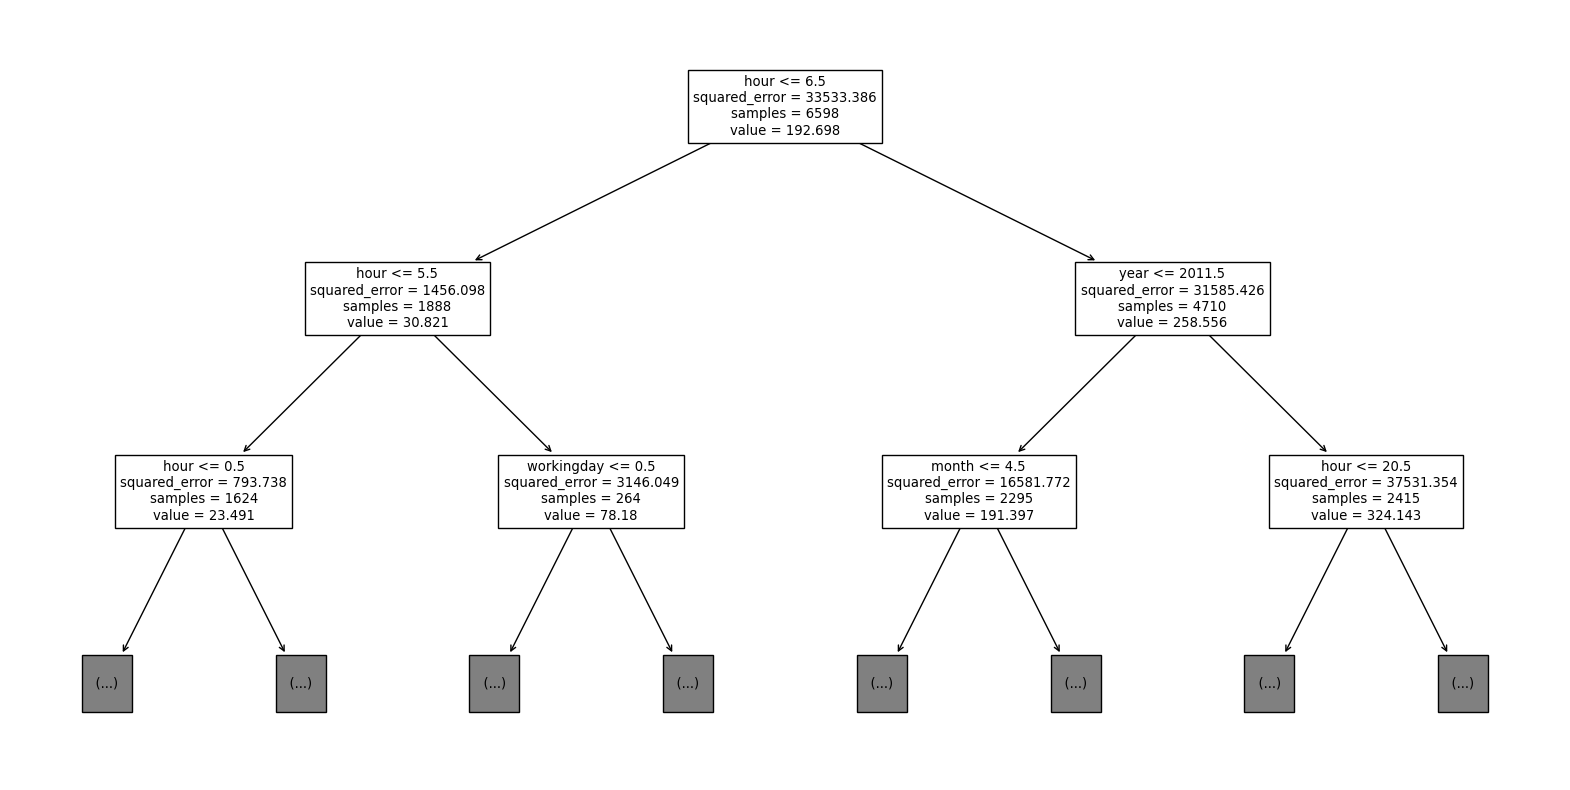

In [71]:
# Look at single trees
chosen_tree = pipe_rf["random_forest"].estimators_[0] #look at the first tree
plt.figure(figsize=(20,10))
tree.plot_tree(chosen_tree, feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [72]:
(chosen_tree.tree_.max_depth, chosen_tree.tree_.node_count)

(31, 12481)

#### Hyper-parameter tuning

Random forest first performs stacking and aggregation, and then takes a subset of features to look at. 

In [80]:
import sklearn
print('The scikit-learn version is {}.'.format(sklearn.__version__))

The scikit-learn version is 1.4.1.post1.


In [73]:
# hyper-parameter tuning
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 1000, num = 10)]
# Number of features to consider at every split
max_features = [0.05, 0.5, 0.7, 1]
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(1, 100, num = 5)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
random_grid

{'n_estimators': [10, 120, 230, 340, 450, 560, 670, 780, 890, 1000],
 'max_features': [0.05, 0.5, 0.7, 1],
 'max_depth': [1, 25, 50, 75, 100, None],
 'min_samples_split': [2, 5, 10],
 'min_samples_leaf': [1, 2, 4],
 'bootstrap': [True, False]}

In [74]:
# hyper-parameter tuning - fit the models on the full sample
rf = RandomForestRegressor(random_state=prng)

# Random search of parameters, using 5 fold cross validation,
# search across 50 different combinations, and use all available cores, evaluate by RMSLE
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=random_grid, n_iter=50, cv=5, scoring="neg_root_mean_squared_log_error", verbose=2, random_state=prng, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_full, y_full)


Fitting 5 folds for each of 50 candidates, totalling 250 fits


RandomizedSearchCV(cv=5,
                   estimator=RandomForestRegressor(random_state=RandomState(MT19937) at 0x27ABC7E7140),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'bootstrap': [True, False],
                                        'max_depth': [1, 25, 50, 75, 100, None],
                                        'max_features': [0.05, 0.5, 0.7, 1],
                                        'min_samples_leaf': [1, 2, 4],
                                        'min_samples_split': [2, 5, 10],
                                        'n_estimators': [10, 120, 230, 340, 450,
                                                         560, 670, 780, 890,
                                                         1000]},
                   random_state=RandomState(MT19937) at 0x27ABC7E7140,
                   scoring='neg_root_mean_squared_log_error', verbose=2)

In [75]:
rf_random.best_params_

{'n_estimators': 780,
 'min_samples_split': 5,
 'min_samples_leaf': 2,
 'max_features': 0.7,
 'max_depth': 75,
 'bootstrap': False}

In [76]:
pd.DataFrame(rf_random.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_n_estimators,param_min_samples_split,param_min_samples_leaf,param_max_features,param_max_depth,param_bootstrap,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
0,2.274044,0.037039,0.044817,0.004928,120,5,1,0.5,None,True,"{'n_estimators': 120, 'min_samples_split': 5, ...",-0.874962,-0.535781,-0.603223,-0.417094,-0.372857,-0.560784,0.177255,22
1,32.734792,1.606246,0.373182,0.072096,780,5,2,0.7,75,False,"{'n_estimators': 780, 'min_samples_split': 5, ...",-0.790470,-0.393225,-0.504582,-0.351197,-0.349147,-0.477724,0.166261,1
2,8.551162,0.520761,0.178258,0.021906,560,10,4,0.5,None,True,"{'n_estimators': 560, 'min_samples_split': 10,...",-0.906622,-0.535068,-0.635968,-0.437633,-0.390250,-0.581108,0.183358,25
3,16.832087,1.080131,0.473455,0.094867,890,2,1,1,25,False,"{'n_estimators': 890, 'min_samples_split': 2, ...",-1.360469,-1.083688,-1.027482,-0.933095,-0.828056,-1.046558,0.179388,26
4,2.320385,0.430538,0.169006,0.054909,890,2,2,1,1,True,"{'n_estimators': 890, 'min_samples_split': 2, ...",-1.910570,-1.408362,-1.602397,-1.366458,-1.307428,-1.519043,0.219342,50
5,8.516312,0.916282,0.087902,0.019140,230,2,4,0.7,50,False,"{'n_estimators': 230, 'min_samples_split': 2, ...",-0.798018,-0.391583,-0.515227,-0.353956,-0.353173,-0.482391,0.168605,5
6,0.272170,0.052486,0.009221,0.001674,10,2,1,0.5,100,True,"{'n_estimators': 10, 'min_samples_split': 2, '...",-0.891352,-0.510066,-0.606788,-0.484606,-0.380363,-0.574635,0.173988,23
7,3.555399,0.342566,0.060674,0.026095,120,5,1,0.7,25,True,"{'n_estimators': 120, 'min_samples_split': 5, ...",-0.827689,-0.404129,-0.541234,-0.366606,-0.342030,-0.496338,0.179417,12
8,2.921597,0.332784,0.125072,0.016142,340,10,2,0.05,100,False,"{'n_estimators': 340, 'min_samples_split': 10,...",-1.399920,-1.128251,-1.084264,-0.977681,-0.878960,-1.093815,0.175856,33
9,0.425280,0.070411,0.010929,0.006593,10,10,2,0.7,50,False,"{'n_estimators': 10, 'min_samples_split': 10, ...",-0.812036,-0.422079,-0.587734,-0.354397,-0.355000,-0.506249,0.175023,14


In [77]:
train_error = calculateRMSLE(rf_random.best_estimator_.predict(X_full), y_full)
test_error = calculateRMSLE(rf_random.best_estimator_.predict(X_test_fe), y_test)
cv_rf_result = ["CV RF large n", train_error, test_error]

rf_results.append(cv_rf_result)
pd.DataFrame(rf_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,RF,0.8172,1.3073
1,Feature engineered RF,0.2081,0.4129
2,Feature engineered RF large n,0.1465,0.2830
3,CV RF large n,0.1159,0.2841


For this particular dataset, the CV RF large n did not really help that much. So, another method will be run. 

### Model #7: XGBoost

#### Technical detour: category type

In [34]:
dummy_features = ["season", "holiday", "workingday", "weather", "year", "month", "day", "hour", "dayofweek"]
X_full[dummy_features] = X_full[dummy_features].astype("category")
X_full.dtypes

season        category
holiday       category
workingday    category
weather       category
temp           float64
atemp          float64
humidity         int64
windspeed      float64
year          category
day           category
month         category
hour          category
dayofweek     category
dtype: object

Why we did not deal with this so far? Because sklearn's implementation of trees [does not handle them differently](https://scikit-learn.org/stable/modules/tree.html#:~:text=and%20categorical%20data.-,However%2C%20the%20scikit%2Dlearn%20implementation%20does%20not%20support%20categorical%20variables%20for%20now.,-Other%20techniques%20are).

In [40]:
!pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/24/ec/ad387100fa3cc2b9b81af0829b5ecfe75ec5bb19dd7c19d4fea06fb81802/xgboost-2.0.3-py3-none-win_amd64.whl.metadata
   ---------------------------------------- 0.0/99.8 MB ? eta -:--:--
   ---------------------------------------- 0.4/99.8 MB 12.6 MB/s eta 0:00:08
   ---------------------------------------- 0.7/99.8 MB 7.6 MB/s eta 0:00:14
    --------------------------------------- 1.5/99.8 MB 11.8 MB/s eta 0:00:09
    --------------------------------------- 1.9/99.8 MB 12.1 MB/s eta 0:00:09
   - -------------------------------------- 2.7/99.8 MB 12.3 MB/s eta 0:00:08
   - -------------------------------------- 3.1/99.8 MB 11.8 MB/s eta 0:00:09
   - -------------------------------------- 3.7/99.8 MB 11.7 MB/s eta 0:00:09
   - -------------------------------------- 4.3/99.8 MB 11.9 MB/s eta 0:00:09
   - -------------------------------------- 4.4/99.8 MB 10.7 MB/s eta 0:00:09
   -- ------------------

In [41]:
from xgboost import XGBRegressor
from sklearn.pipeline import Pipeline

In [45]:
steps = [
    ("deep_tree", tree.DecisionTreeRegressor(max_depth=10, random_state=prng))
]
pipe_tree_deep = Pipeline(steps)

# Illustration
pipe_tree_deep.fit(X_full, y_full)

train_error = calculateRMSLE(pipe_tree_deep.predict(X_full), y_full)
test_error = calculateRMSLE(pipe_tree_deep.predict(X_test_fe), y_test)

tree_results.append(["Deep tree large n categories", train_error, test_error])

pd.DataFrame(tree_results, columns = ["Model", "Train", "Test"])

,Model,Train,Test
0,Tree,1.0202,1.3876
1,Feature engineered tree,0.2594,0.5031
2,Feature engineered tree large n,0.2965,0.3640
3,Deep tree large n categories,0.2965,0.3645
4,Deep tree large n categories,0.2965,0.3636


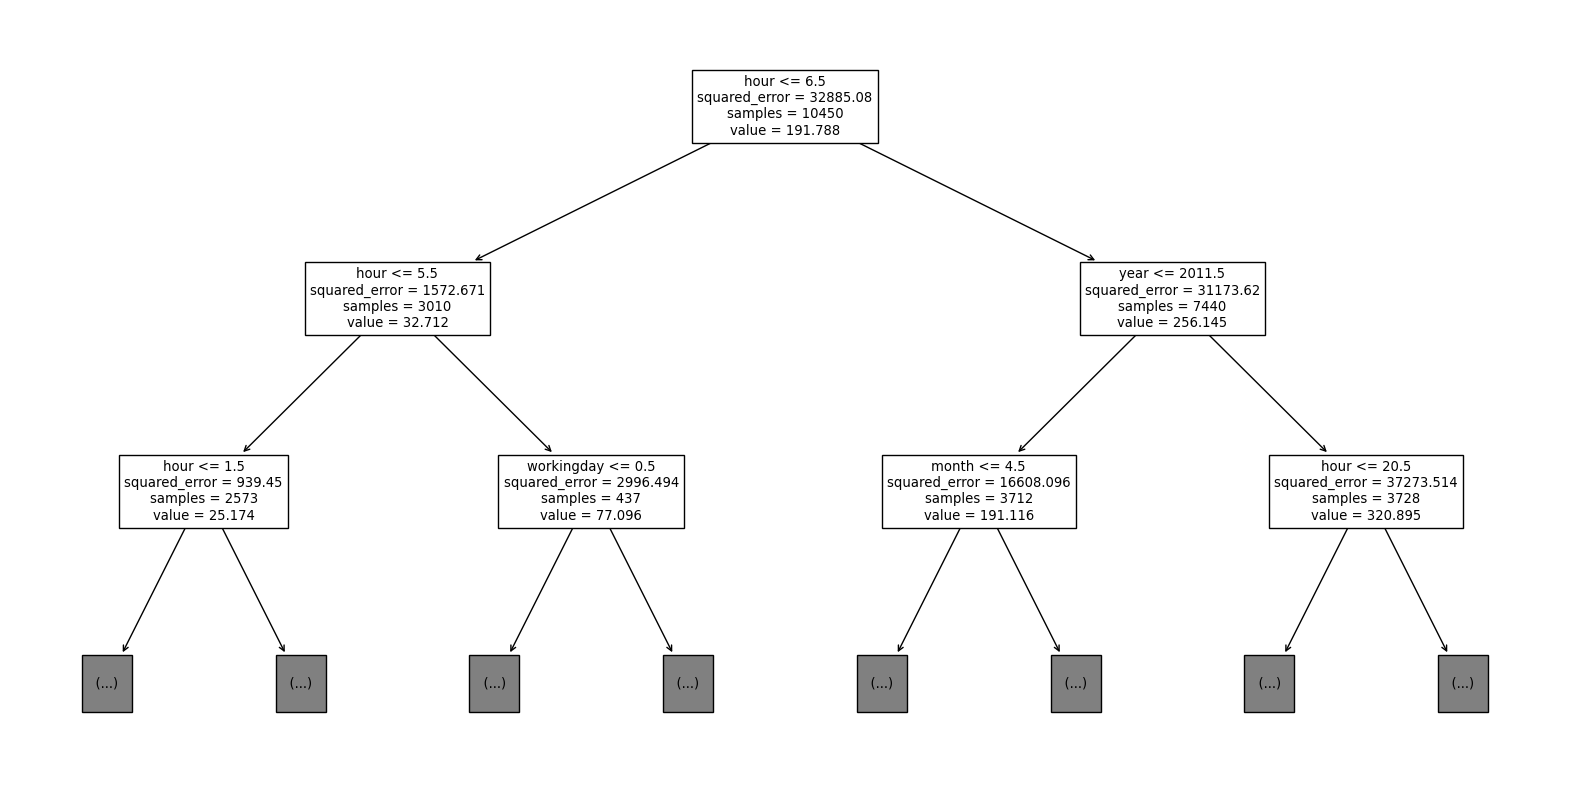

In [46]:
plt.figure(figsize=(20,10))
tree.plot_tree(pipe_tree_deep["deep_tree"], feature_names = X_full.columns.to_list(), max_depth=2)
plt.show()

In [47]:
# Boosted tree: xgboost
import xgboost as xgb
xgb_model = xgb.XGBRegressor(enable_categorical=True).fit(X_full, y_full)

In [48]:
train_error = calculateRMSLE(xgb_model.predict(X_full), y_full)
test_error = calculateRMSLE(xgb_model.predict(X_test_fe), y_test)

["XGB", train_error, test_error]

['XGB', 0.3587, 0.6816]

The error is actually quite large as compared to what we achieved with random forest. We could ahve done some hyperparameter tuning. 

In [49]:
xgb_model.get_booster().trees_to_dataframe().head()

,Tree,Node,ID,Feature,Split,Yes,No,Missing,Gain,Cover,Category
0,0,0,0-0,hour,NaN,0-2,0-1,0-1,123864184.0,10450.0,"[0, 1, 2, 3, 4, 5, 6, 22, 23]"
1,0,1,0-1,hour,NaN,0-4,0-3,0-3,35166384.0,6562.0,"[0, 1, 2, 3, 4, 5, 6, 7, 9, 10, 11, 12, 13, 14..."
2,0,2,0-2,hour,NaN,0-6,0-5,0-5,4799192.0,3888.0,"[0, 1, 2, 3, 4, 5]"
3,0,3,0-3,workingday,NaN,0-8,0-7,0-7,18107248.0,1319.0,[0]
4,0,4,0-4,year,NaN,0-10,0-9,0-9,19066454.0,5243.0,[0]


Here, we have a sequence of elements. This is something we could not have achieved with the tree. The first interation has a gain similar to the other gains as well. 

### Submit to Kaggle

[Kaggle Data](https://www.kaggle.com/c/bike-sharing-demand)

In [96]:
# TODO
bike_test = pd.read_csv("https://raw.githubusercontent.com/divenyijanos/ceu-ml/2023/data/bike_sharing_demand/bike_sample.csv")
extract_dt_features(bike_test)


to_submit = pd.DataFrame({
    'datetime': bike_test.datetime.dt.strftime('%Y-%m-%d %H:%M:%S'),
    'count': pipe_rf.predict(bike_test.drop(columns=["datetime", "count", "casual", "registered"]))
})


to_submit.to_csv('C:/Users/iandr/masters_coding/Second Semester/Data_Science/Data_Science_2/bike_prediction.csv', index=False)


In [87]:
bike_test.shape

(2177, 12)

## Predict heart failure


We are going to work with a heart disease data set collected from 5 different sources (for more detailed information consult [Kaggle](https://www.kaggle.com/datasets/fedesoriano/heart-failure-prediction)). It contains health condition data about 460 patients and whether they got a heart attack. We will use the subset of this dataset and preserve the rest for evaluating our final model on Kaggle.

Cardiovascular diseases (CVDs) are [the most common cause of death globally](https://ourworldindata.org/cardiovascular-diseases) making this task particularly relevant. As the competition states: _"People with cardiovascular disease or who are at high cardiovascular risk (due to the presence of one or more risk factors) need early detection and management wherein a machine learning model can be of great help."_

Attribute Information:
- `Age`: age of the patient [years]
- `Sex`: sex of the patient [M: Male, F: Female]
- `ChestPainType`: chest pain type [TA: Typical Angina, ATA: Atypical Angina, NAP: Non-Anginal Pain, ASY: Asymptomatic]
- `RestingBP`: resting blood pressure [mm Hg]
- `Cholesterol`: serum cholesterol [mm/dl]
- `FastingBS`: fasting blood sugar [1: if FastingBS > 120 mg/dl, 0: otherwise]
- `RestingECG`: resting electrocardiogram results [Normal: Normal, ST: having ST-T wave abnormality (T wave inversions and/or ST elevation or depression of > 0.05 mV), LVH: showing probable or definite left ventricular hypertrophy by Estes' criteria]
- `MaxHR`: maximum heart rate achieved [Numeric value between 60 and 202]
- `ExerciseAngina`: exercise-induced angina [Y: Yes, N: No]
- `Oldpeak`: oldpeak = ST [Numeric value measured in depression]
- `ST_Slope`: the slope of the peak exercise ST segment [Up: upsloping, Flat: flat, Down: downsloping]
- `HeartDisease`: output class [1: heart disease, 0: Normal]

### Know your data

In [191]:
import os

current_dir = os.getcwd()
#heart_data = pd.read_csv("https://github.com/Iandrewburg/ceu-ml/raw/2023/data/heart_failure/heart.csv")
heart_data = pd.read_csv("C:/Users/iandr/masters_coding/Second Semester/Data_Science/Data_Science_2/heart_train.csv")
heart_test = pd.read_csv("C:/Users/iandr/masters_coding/Second Semester/Data_Science/Data_Science_2/heart_holdout.csv")
#heart_data = pd.concat([heart_train, heart_test], axis=0)
#heart_data.reset_index(drop=True, inplace=True)


In [192]:
heart_data.shape

(345, 13)

In [220]:
heart_test.shape

(115, 12)

In [194]:
heart_data.dtypes

Unnamed: 0          int64
Age                 int64
Sex                object
ChestPainType      object
RestingBP           int64
Cholesterol         int64
FastingBS           int64
RestingECG         object
MaxHR               int64
ExerciseAngina     object
Oldpeak           float64
ST_Slope           object
HeartDisease        int64
dtype: object

Target variable to predict is HeartDisease

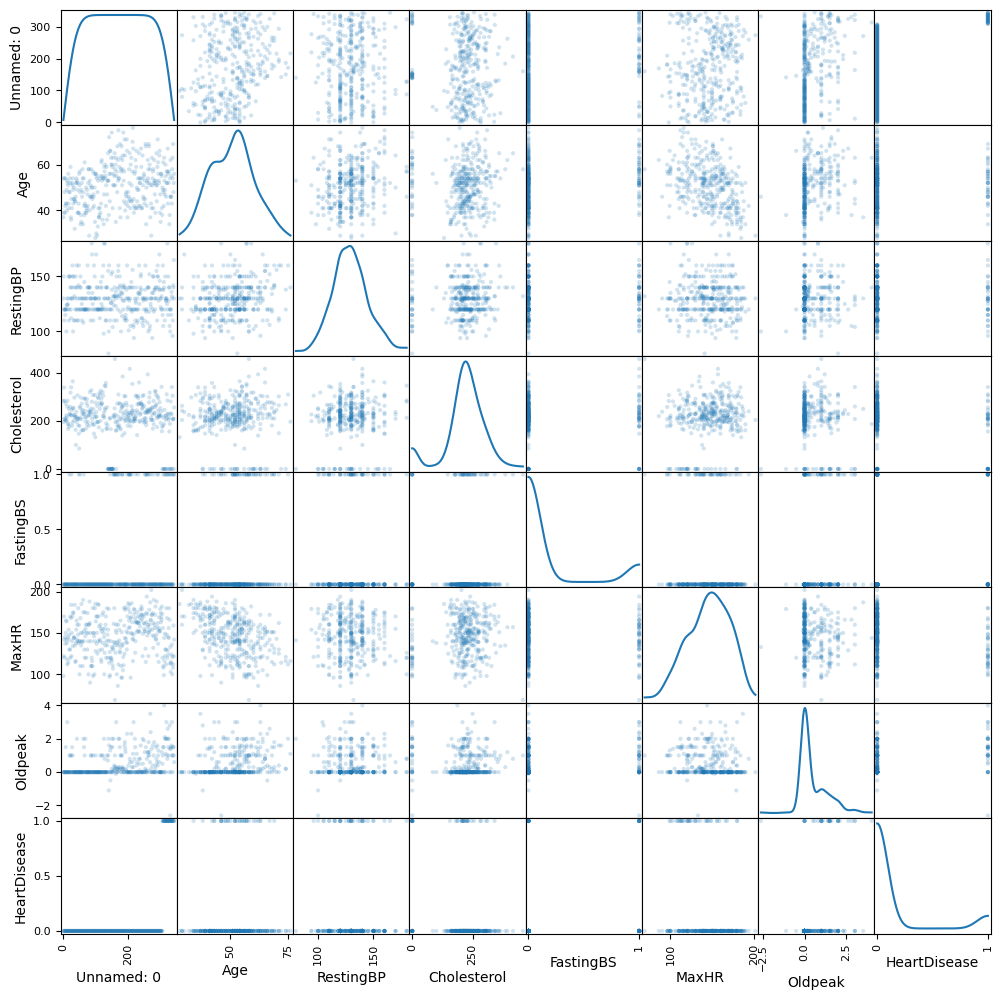

In [195]:
from pandas.plotting import scatter_matrix
scatter_matrix(heart_data, alpha=0.2, figsize=(12, 12), diagonal="kde");


### Train-test split

In [196]:
features = heart_data.drop(columns=["HeartDisease"])
label = heart_data["HeartDisease"]

prng = np.random.RandomState(20240311)
X_train, X_test, y_train, y_test = train_test_split(features, label, test_size=0.2, random_state=prng)



### Benchmark evaluation

In [197]:
# benchmark accuracy
from sklearn.metrics import accuracy_score

def calculateAccuracy(observed, predicted):
    return round(accuracy_score(observed, predicted), 4)

benchmark_prediction = np.bincount(y_train).argmax()
train_accuracy = calculateAccuracy(y_train, np.repeat(benchmark_prediction, len(y_train)))
test_accuracy = calculateAccuracy(y_test, np.repeat(benchmark_prediction, len(y_test)))
[train_accuracy, test_accuracy]

[0.8768, 0.9565]

In [198]:
# confusion matrix
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, np.repeat(benchmark_prediction, len(y_test)))
cm

array([[66,  0],
       [ 3,  0]], dtype=int64)

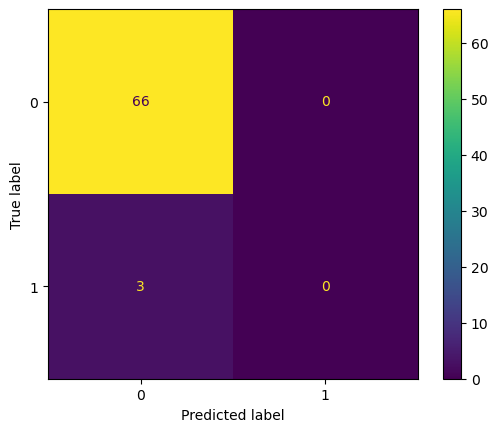

In [199]:
from sklearn.metrics import ConfusionMatrixDisplay

display = ConfusionMatrixDisplay(confusion_matrix=cm)
display.plot()
plt.show()

In [200]:
from sklearn.metrics import precision_score, recall_score

def calculateMetrics(observed, predicted):
    return {
        "accuracy": calculateAccuracy(observed, predicted),
        "precision": round(precision_score(observed, predicted), 4),
        "recall": round(recall_score(observed, predicted), 4)
    }

pd.DataFrame(
    [calculateMetrics(y, np.repeat(benchmark_prediction, len(y))) for y in [y_train, y_test]],
    index=["Train", "Test"]
)


C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\iandr\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1509: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


,accuracy,precision,recall
Train,0.8768,0.0,0.0
Test,0.9565,0.0,0.0


### Benchmark #2: Logistic regression

#### Pipeline with preprocessing and estimation

In [201]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

one_hot_encoder = OneHotEncoder(sparse_output=False, drop="first")
categorical_vars = heart_data.select_dtypes(include="object").columns.to_list()

column_transformer = ColumnTransformer(
    [("create_dummies", one_hot_encoder, categorical_vars)],
    remainder="passthrough"
)

In [202]:
# logit
from sklearn.preprocessing import MinMaxScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

pipe_logit = Pipeline([
    ("transform", column_transformer),
    ("scale", MinMaxScaler()),
    ("logit", LogisticRegression())
])

pipe_logit.fit(X_train, y_train)

Pipeline(steps=[('transform',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope'])])),
                ('scale', MinMaxScaler()), ('logit', LogisticRegression())])

In [203]:
pipe_logit.predict(X_train)

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0], dtype=int64)

In [204]:
pd.DataFrame(
    [calculateMetrics(y, pipe_logit.predict(x)) for x, y in [(X_train, y_train), (X_test, y_test)]],
    index=["Train", "Test"]
)

,accuracy,precision,recall
Train,0.9710,0.9643,0.7941
Test,0.9565,0.5000,0.3333


#### ROC curve

In [205]:
# To use a different cutoff we need to predict probabilities first
pipe_logit.predict_proba(X_train)[:5, :]  # look at first 5 results

array([[0.90545674, 0.09454326],
       [0.99652902, 0.00347098],
       [0.99301988, 0.00698012],
       [0.93169749, 0.06830251],
       [0.98126135, 0.01873865]])

In [206]:
def predictProbs(model, X):
    return model.predict_proba(X)[:, 1]

def predictWithCutoff(model, X, cutoff):
    return (predictProbs(model, X) >= cutoff).astype(int)

cutoff = 0.3
pd.DataFrame(
    [calculateMetrics(y, predictWithCutoff(pipe_logit, x, cutoff)) for x, y in [(X_train, y_train), (X_test, y_test)]],
    index=["Train", "Test"]
)

,accuracy,precision,recall
Train,0.9674,0.8571,0.8824
Test,0.9710,0.6667,0.6667


In [207]:
# ROC
from sklearn.metrics import roc_curve, roc_auc_score

y_scores = predictProbs(pipe_logit, X_test)
fpr, tpr, thresholds = roc_curve(y_test, y_scores) 
print(f"thresholds: {thresholds}\n")
print(f"FPR: {fpr}\n")
print(f"TPR: {tpr}\n")

thresholds: [       inf 0.9331372  0.57355694 0.42649194 0.24966105 0.24127365
 0.00104924]

FPR: [0.         0.         0.01515152 0.01515152 0.03030303 0.03030303
 1.        ]

TPR: [0.         0.33333333 0.33333333 0.66666667 0.66666667 1.
 1.        ]



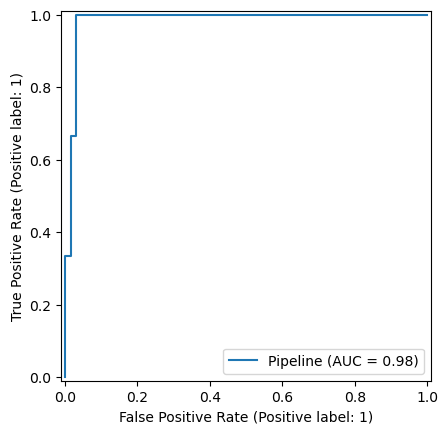

In [208]:
from sklearn.metrics import RocCurveDisplay

roc_display = RocCurveDisplay.from_estimator(pipe_logit, X_test, y_test)
plt.show(roc_display)

#### Precision-recall plot

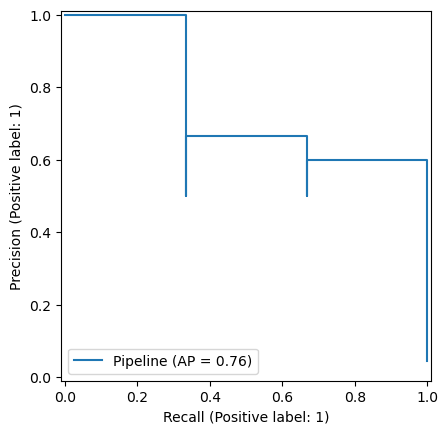

In [209]:
from sklearn.metrics import PrecisionRecallDisplay, precision_recall_curve

PrecisionRecallDisplay.from_estimator(pipe_logit, X_test, y_test)

#### Imputation

In [210]:
# Imputation
from sklearn.impute import KNNImputer

change_zero_cholesterol_to_closest_neighbors = KNNImputer(missing_values=0)

column_transformer_with_imputation = ColumnTransformer(
    [
        ("create_dummies", one_hot_encoder, categorical_vars),
        ("impute_cholesterol", change_zero_cholesterol_to_closest_neighbors, ["Cholesterol"])
    ],
    remainder="passthrough"
)
pipe_logit_with_imputation = Pipeline([
    ("preprocess", column_transformer_with_imputation),
    ("scale", MinMaxScaler()),
    ("logit" , LogisticRegression(penalty=None, random_state=prng))
])
pipe_logit_with_imputation

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('impute_cholesterol',
                                                  KNNImputer(missing_values=0),
                                                  ['Cholesterol'])])),
                ('scale', MinMaxScaler()),
                ('logit',
                 LogisticRegression(penalty=None,
                                    random_state=RandomState(MT19937) at 0x27B46E39D40))])

In [211]:
pipe_logit_with_imputation.fit(X_train, y_train)

Pipeline(steps=[('preprocess',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('create_dummies',
                                                  OneHotEncoder(drop='first',
                                                                sparse_output=False),
                                                  ['Sex', 'ChestPainType',
                                                   'RestingECG',
                                                   'ExerciseAngina',
                                                   'ST_Slope']),
                                                 ('impute_cholesterol',
                                                  KNNImputer(missing_values=0),
                                                  ['Cholesterol'])])),
                ('scale', MinMaxScaler()),
                ('logit',
                 LogisticRegression(penalty=None,
                                    random_state=RandomState(MT19937) at 0x27B46E39D40))])

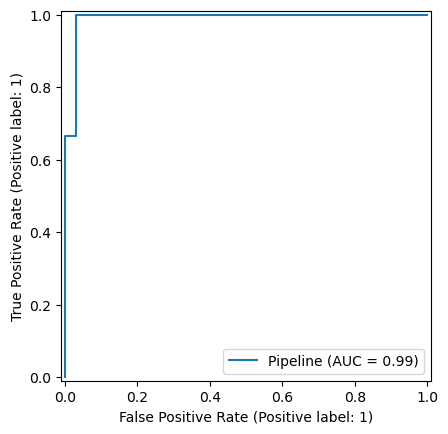

In [212]:
roc_display_imputed = RocCurveDisplay.from_estimator(pipe_logit_with_imputation, X_test, y_test)

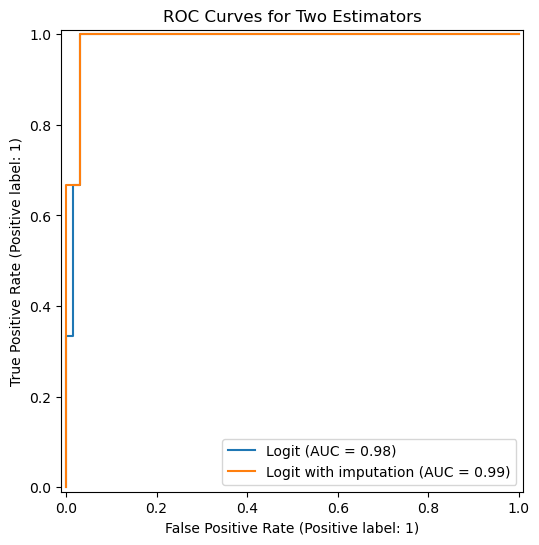

In [213]:
fig, ax = plt.subplots(figsize=(8, 6))
roc_display.plot(ax=ax, name="Logit")
roc_display_imputed.plot(ax=ax, name="Logit with imputation")
plt.title('ROC Curves for Two Estimators')
plt.show()

In [229]:
# Use the limited data for prediction to ensure it's only 115 rows if needed
heart_data_limited = heart_data.iloc[:115]
heart_test = heart_test.drop(columns=['HeartDisease'])

# Update the DataFrame to include a column with predictive probabilities for the positive class
to_submit = pd.DataFrame({
    'HeartDisease': pipe_logit_with_imputation.predict_proba(X_test)[:, 1],  # Probability of '1' for Heart Disease
    'ID': X_test.index  # Assuming you're limiting the predictions to the first 115 rows
})
to_submit.to_csv('C:/Users/iandr/masters_coding/Second Semester/Data_Science/Data_Science_2/heart_prediction.csv', index=False)

KeyError: "['HeartDisease'] not found in axis"

### autoML
Some of the ML processes are easy to automate (e.g. hyper-parameter tuning, model evaluation and selection). There are many tools that solve this automation task, e.g. the [auto-sklearn package](https://automl.github.io/auto-sklearn/master/).